#### Print your name

In [1]:
## Your code here 
print("Exercise by: Heidi Putkuri")

Exercise by: Heidi Putkuri


# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [2]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here I'll create a model like normal, using the same one from my solution for part 4.

In [3]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [4]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [5]:
top_p, top_class = ps.topk(1, dim=1) # top k values and classes
# Look at the most likely classes for the first 10 examples
# note. At this point the network is not trained!

print(top_class[:10,:]) # this prints the top 10 classes
print("Correct labels:", labels[:10]) # this prints the correct labels for the top 10 classes

tensor([[3],
        [3],
        [1],
        [3],
        [3],
        [1],
        [1],
        [3],
        [1],
        [1]])
Correct labels: tensor([9, 6, 6, 2, 6, 4, 5, 2, 9, 3])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [6]:
equals = top_class == labels.view(*top_class.shape)

In [7]:
# the 10 first from equals tensor
print(equals[:10])

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])


Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [8]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 4.6875%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```


***
### Exercise: 
Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

**Hint.** Use this frame for your solution
```python

train_losses1 = []
test_losses1 = []
test_accuracy1 = []

model1 = Classifier()
criterion1 = nn.NLLLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.003)

epochs = 30
steps = 0

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model1(images)
        loss = criterion1(log_ps, labels)
        loss.backward()
        optimizer1.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
```

In [9]:
## Task 1:
## Your code here 

train_losses1 = []
test_losses1 = []
test_accuracy1 = []

model1 = Classifier()
criterion1 = nn.NLLLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.003)

epochs = 30
steps = 0
for e in range(epochs):
    running_loss = 0  # Reset training loss for the epoch

    for images, labels in trainloader:
        optimizer1.zero_grad()
        
        log_ps = model1(images)  # Forward pass, returns log probabilities
        loss = criterion1(log_ps, labels)  # Calculate the NLL loss comparing log probabilities and true labels
        loss.backward()  # Backpropagation to calculate gradients for weights using loss
        optimizer1.step()  # Update the weights using gradients calculated in backpropagation
        running_loss += loss.item() 

    train_losses1.append(running_loss / len(trainloader))

    test_loss = 0 
    accuracy = 0   # Reset accuracy

    with torch.no_grad():  # Turn off gradients for validation
        for images, labels in testloader:
            log_ps = model1(images)  # Forward pass
            loss = criterion1(log_ps, labels)
            test_loss += loss.item() 

            class_probabilities = torch.exp(log_ps)  # Convert log probabilities to probabilities
            top_p, top_class = class_probabilities.topk(1, dim=1)  #get the top class and its probability
            equals = top_class == labels.view(*top_class.shape)  # Compare with true labels
            accuracy += torch.sum(equals).item()  # Count correct predictions

    test_losses1.append(test_loss / len(testloader))  # calculate average test loss for the epoch
    test_accuracy1.append(accuracy / len(testloader.dataset)) # calculate average test accuracy for the epoch

    print(f'Epoch: {e+1}/{epochs}.. '
            f'Training loss: {train_losses1[-1]:.3f}.. '
            f'Test loss: {test_losses1[-1]:.3f}.. '
            f'Test accuracy: {test_accuracy1[-1]:.3f}')


Epoch: 1/30.. Training loss: 0.520.. Test loss: 0.444.. Test accuracy: 0.840
Epoch: 2/30.. Training loss: 0.393.. Test loss: 0.438.. Test accuracy: 0.843
Epoch: 3/30.. Training loss: 0.355.. Test loss: 0.420.. Test accuracy: 0.852
Epoch: 4/30.. Training loss: 0.334.. Test loss: 0.397.. Test accuracy: 0.863
Epoch: 5/30.. Training loss: 0.320.. Test loss: 0.396.. Test accuracy: 0.868
Epoch: 6/30.. Training loss: 0.303.. Test loss: 0.383.. Test accuracy: 0.868
Epoch: 7/30.. Training loss: 0.295.. Test loss: 0.357.. Test accuracy: 0.876
Epoch: 8/30.. Training loss: 0.286.. Test loss: 0.364.. Test accuracy: 0.876
Epoch: 9/30.. Training loss: 0.276.. Test loss: 0.364.. Test accuracy: 0.877
Epoch: 10/30.. Training loss: 0.269.. Test loss: 0.377.. Test accuracy: 0.873
Epoch: 11/30.. Training loss: 0.260.. Test loss: 0.356.. Test accuracy: 0.879
Epoch: 12/30.. Training loss: 0.254.. Test loss: 0.383.. Test accuracy: 0.876
Epoch: 13/30.. Training loss: 0.251.. Test loss: 0.379.. Test accuracy: 0

In [10]:
#import plotly.graph_objects as go

#fig = go.Figure()
#fig.add_trace(go.Scatter(x=list(range(epochs)), y=train_losses1, mode='lines', name='Training loss'))
#fig.add_trace(go.Scatter(x=list(range(epochs)), y=test_losses1, mode='lines', name='Test loss'))
#fig.update_layout(
#    title='Training and Test loss',
#    plot_bgcolor='white'
#)

#fig.update_xaxes(
#    mirror=True,
#    ticks='outside',
#    showline=True,
#    linecolor='black',
#    gridcolor='lightgrey'
#)
#fig.update_yaxes(
#    mirror=True,
#   ticks='outside',
#    showline=True,
#    linecolor='black',
#    gridcolor='lightgrey'
#)

***
## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='../data/assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

***
### Exercise:

**Part A**: Define network with dropout.

In [11]:
## Task 2:
## Your code here 


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)  
        # https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html:
        # During training, randomly zeroes some of the elements of the input tensor with probability p.
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        # droup on each layer in the forward pass
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x))) 
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x 




***
**Part B**: Train the network with Fashion-MNIST again.
- monitor the training progress with the validation loss and accuracy

In [18]:
## Task 3:
## Your code here 
train_losses2 = []
test_losses2 = []
test_accuracy2 = []
model2 = Classifier()
criterion2 = nn.NLLLoss() 
optimizer2 = optim.Adam(model2.parameters(), lr=0.003)

epochs = 30
steps = 0 # 

for e in range(epochs):
    running_loss = 0
    test_loss = 0 
    accuracy = 0


    model2.train()
    for images, labels in trainloader:
        optimizer2.zero_grad() # zero the previous epochs gradients
        log_ps = model2(images) # forward pass to make the 'predictions' -> in log propabilities
        loss = criterion2(log_ps, labels) # calculate loss 
        loss.backward() # backward pass to calculate the gradients 
        optimizer2.step() # updating the weights
        running_loss += loss.item() # add the loss to the running loss
    
    train_losses2.append(running_loss / len(trainloader))

    with torch.no_grad():
        model2.eval()
        for images, labels in testloader:
            log_ps = model2(images)
            loss = criterion2(log_ps, labels)
            test_loss += loss.item() 

            class_probabilities = torch.exp(log_ps)  # Convert log probabilities to probabilities
            top_p, top_class = class_probabilities.topk(1, dim=1)  #get the top class and its probability
            equals = top_class == labels.view(*top_class.shape)  # Compare with true labels
            accuracy += torch.sum(equals).item()  # Count correct predictions 

    test_losses2.append(test_loss / len(testloader))  # calculate average test loss for the epoch
    test_accuracy2.append(accuracy / len(testloader.dataset)) # calculate average test accuracy for the epoch

    print(f'Epoch: {e+1}/{epochs}.. '
            f'Training loss: {train_losses2[-1]:.3f}.. '
            f'Test loss: {test_losses2[-1]:.3f}.. '
            f'Test accuracy: {test_accuracy2[-1]:.3f}')


Epoch: 1/30.. Training loss: 0.602.. Test loss: 0.492.. Test accuracy: 0.818
Epoch: 2/30.. Training loss: 0.474.. Test loss: 0.443.. Test accuracy: 0.836
Epoch: 3/30.. Training loss: 0.448.. Test loss: 0.428.. Test accuracy: 0.848
Epoch: 4/30.. Training loss: 0.431.. Test loss: 0.442.. Test accuracy: 0.843
Epoch: 5/30.. Training loss: 0.418.. Test loss: 0.393.. Test accuracy: 0.863
Epoch: 6/30.. Training loss: 0.410.. Test loss: 0.394.. Test accuracy: 0.863
Epoch: 7/30.. Training loss: 0.400.. Test loss: 0.397.. Test accuracy: 0.863
Epoch: 8/30.. Training loss: 0.387.. Test loss: 0.397.. Test accuracy: 0.857
Epoch: 9/30.. Training loss: 0.394.. Test loss: 0.398.. Test accuracy: 0.859
Epoch: 10/30.. Training loss: 0.390.. Test loss: 0.384.. Test accuracy: 0.866
Epoch: 11/30.. Training loss: 0.377.. Test loss: 0.396.. Test accuracy: 0.855
Epoch: 12/30.. Training loss: 0.380.. Test loss: 0.361.. Test accuracy: 0.868
Epoch: 13/30.. Training loss: 0.373.. Test loss: 0.376.. Test accuracy: 0

***
**Part C**: Plot training loss and validation loss to see if you can get a lower validation loss or higher accuracy.

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

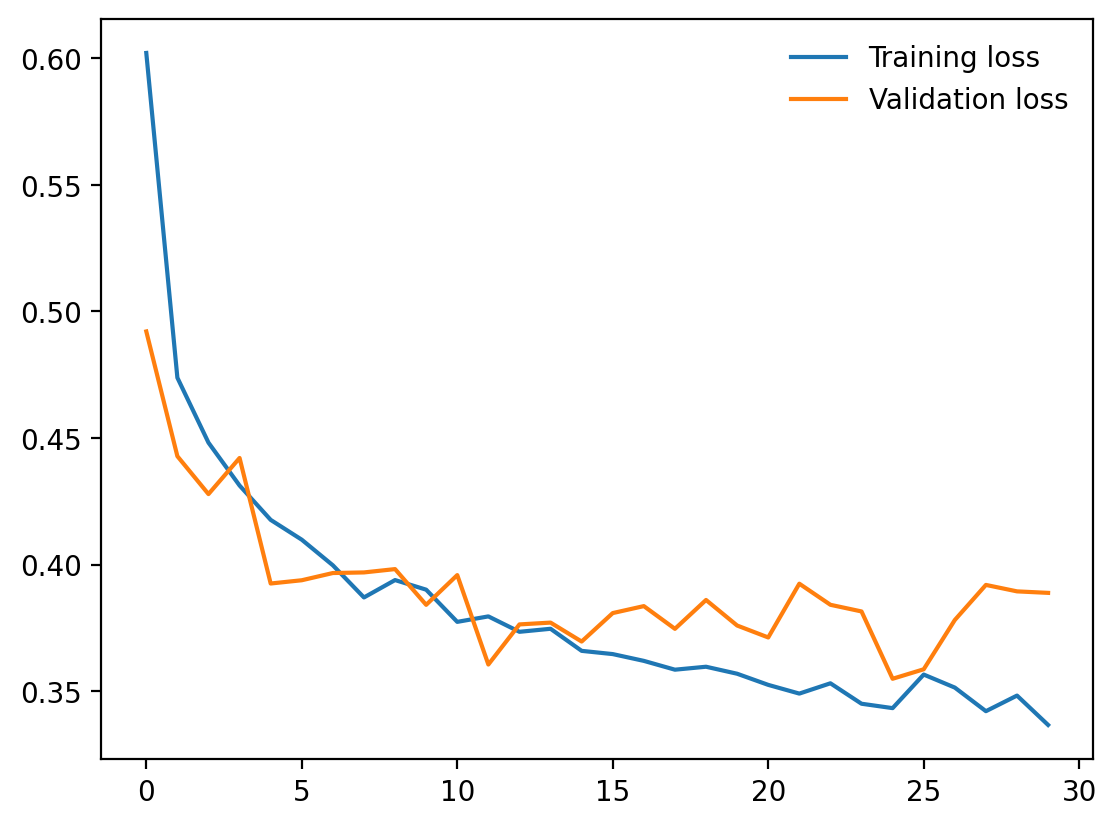

In [22]:
## Task 4:
## Your code here 

plt.plot(train_losses2, label='Training loss')
plt.plot(test_losses2, label='Validation loss')
plt.legend(frameon=False)
plt.show()



***
### More about overfitting 

"Dropout" method helps to cope with overfitting. However it makes model debuging bit harder and you must remember to turn dropout OFF while using the network, i.e. dropout is used only in training. But don't worry Pytorch will do it for you if you remember initialize dropout 

```python
# Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
```

and set model to evaluation mode
        
```python
# set model to evaluation mode
    model.eval()
```       

these are not preferred method for overfitting.

#### Other methods to cope with overfitting

##### Early-stopping

Training stopping at the point where it reaches best performance (= minimum error/loss), is also used to cope with overfitting, but this is not recommended because this limits training data usage to some maximum amount. And because modern deep learning models are based to training with big data amounts, this is very tricky combination...

<img src='../data/assets/Early_stopping.svg' width=400px>


##### Regulation
Another very popular method for overfitting is regularization. This method is based on target to minimize weights (=co-efficients = w) in the network. This is done by adding the `|w|` or `|w|^2` to loss function.

<img src='../data/assets/Error_function_reg.svg' width=700px>



## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

Label: 8


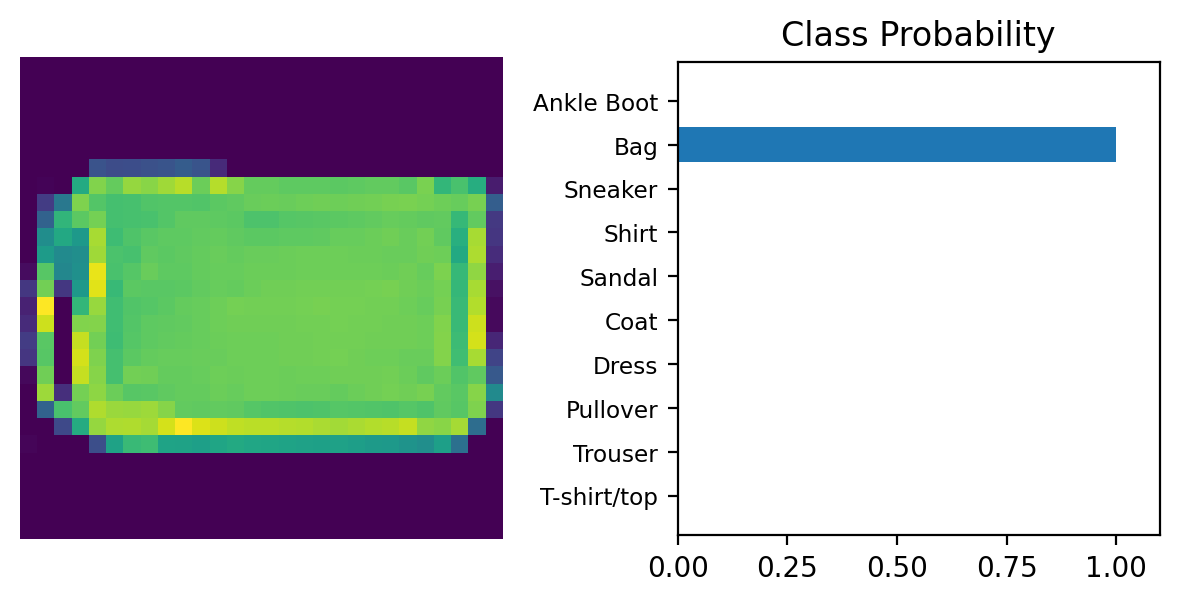

In [21]:
# Import helper module (should be in the repo)
import sys
sys.path.insert(0, '../answers')
import helper

# Test out your network!

model2.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model2.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

print('Label:', labels[0].item())

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.

## Reflection

Answer briefly following questions (in English or Finnish):
- What is overfitting?
- How you can avoid overfitting?

#### Network Performance

- Does network Training Loss decrease monotonously? What about Validation Loss?
- Is the performance better when using dropout with 20% drop rate? What about if you change drop rate?


**Overfitting** 
Over fitting on the test data happens when the model becomes too complex and learns the detail and patterns from noise in the training data to the extent that it negatively impacts the performance of the model on new data (on the validation/test data). This can also happen if the data contains noise or the number of samples is too small.

**Avoiding overfitting**
Avoiding this can be done in many ways which include:
1) Simplifying the model by selecting a model with fewer parameters, reducing the number of attributes in the training data, or constraining the model.
2) More data for the training
3) Regularization:
    - L1 regularization: adds a penalty equal to the absolute value of the magnitude of coefficients to the loss function
    - L2 regularization: adds a penalty equal to the square of the magnitude of coefficients to the loss function
4) Drop out: randomly setting a fraction of the input units to 0 at each update during training
5) Early stopping: stopping the training process when the model performance on the validation set starts to degrade.


**Network Performance**

Without dropout, the training loss decreases monotonically, meaning the model is progressively learning to minimize the error on the training data. The validation loss fluctuates. It generally decreases initially but starts to increase and decrease at later epochs, which suggests that the model is starting to overfit.

With the dropout (20%), the training loss decreases steadily, indicating that the model is learning. Compared to the model without dropout, the rate of the decrease is slower. The validation loss still fluctuates and more in comparison to the model without dropout, but this is expected because dropout introduces randomness into the training process, which can affect the model’s ability to consistently generalize.



Sources:
[Hands-On Machine Learning with Scikit-Learn & TensorFlow](https://www.adlibris.com/fi/kirja/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow-3e-9781098125974?utm_source=google&utm_medium=cpc&utm_campaign=AR-FI:%20BOK%20-%20pMAX%20Shopping%20-%20Generic%20-%20B%C3%B6cker%20ENG%20+%20SV&gad_source=1&gclid=CjwKCAiAqrG9BhAVEiwAaPu5zlkJsmC2JTm73EzyCBejwbDEGM8R3Q73eo7YAvrsnnPMUsvRuKxvyxoCg2IQAvD_BwE)



### Check your answers by running following cell:

In [23]:
# Do not change this code!

import sys
sys.path.insert(0, '../answers/part5/')
from part5_check import *


print("Results:\n")

print("Without dropout:")
print(model1)
print(criterion1)
print(optimizer1)

print("\nWith dropout:")
print(model2)
print(criterion2)
print(optimizer2)

losses_check(train_losses1, test_losses1, train_losses2, test_losses2)
accuracies_check(test_accuracy1, test_accuracy2)


Results:

Without dropout:
Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
NLLLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)

With dropout:
Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
NLLLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fus

### Great work!